# ПРОЕКТ: РАЗМЕТКА ДОКУМЕНТА

#### Intro

Входящие данные: файл InDesign со стандартной стилевой разметкой

Исходящие данные: файл InDesign с расширенной разметкой 


#### Краткий план

Файл разбивается на абзацы, каждый абзац парсится на предмет всех его свойств (таких как стиль, кегль, гарнитура etc.), из которых формируются признаки для модели машинного обучения.

Далее размечается целевой признак (вручную) по классам.  
Большинство классов будут соответствовать стилю абзаца, добавятся лишь начала/концы вставочных элементов:
* преамбул;
* примеров;
* тематических вставок etc.

Далее проведем EDA полученного датасета, займемся генерацией новых признаков и т. д.

После получения готового к машинному обучению набора данных обучим несколько моделей, чтобы выявить лучшую.

Метрика качества (предварительно) - F1.

По итогу выбора лучшей модели прогоним ее на тестовом файле, из которого формируется датасет аналогичным образом.


## Подготовка и загрузка данных

In [141]:
# improts
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import win32com.client

from catboost import CatBoostClassifier, Pool, cv
from category_encoders import MEstimateEncoder
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    recall_score, 
    precision_score, 
    accuracy_score
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
import torch
import transformers
from tqdm import notebook




#Random state
RS = 45364

#Parameters
app = win32com.client.Dispatch('InDesign.Application.2023')
plt.rcParams["figure.figsize"] = (12, 8)



In [255]:

my_doc = app.ActiveDocument


def get_main_story():
    '''
    Return max story in document
    '''

    story_lens = []

    for i in range(1, my_doc.Stories.Count):
        story_lens.append(my_doc.Stories.Item(i).Paragraphs.Count)


    print('Max story length:', max(story_lens), '\nStories:', len(story_lens), '\nMax story index:', story_lens.index(max(story_lens)))

    main_story = my_doc.Stories[story_lens.index(max(story_lens))]

    print('Paragraphs in max story:', (main_story.Paragraphs.Count))

    return main_story


In [ ]:

main_story = get_main_story()


In [51]:
my_doc.paragraphStyleGroups.item(2).paragraphStyleGroups.item(4).name


# my_doc.paragraphStyleGroups.item(2).paragraphStyleGroups.item(3) - Преамбулы


'Рисунок'

In [52]:
def add_styles():
    try:
        eqn_end = my_doc.paragraphStyleGroups.item(2).paragraphStyleGroups.item(1).paragraphStyles.Add()
        eqn_end.basedOn = my_doc.paragraphStyleGroups.item(2).paragraphStyleGroups.item(1).paragraphStyles.Item("Пример с плашкой_Конец")
        eqn_end.Name = "Пример формула конец"
        eqn_end.firstLineIndent = 0
        eqn_end.spaceBefore = 4
        eqn_end.Justification = 1667591796 # 'CENTER_ALIGN'
        eqn_end.ruleBelow = True
        eqn_end.ruleBelowLineWeight = 0.5
        eqn_end.ruleBelowOffset = 4
    #print(eqn_end.name)


        pic_end = my_doc.paragraphStyleGroups.item(2).paragraphStyleGroups.item(1).paragraphStyles.Add()
        pic_end.basedOn = my_doc.paragraphStyleGroups.item(2).paragraphStyleGroups.item(4).paragraphStyles.Item("Подрисуночная подпись")
        pic_end.Name = "Пример рисунок конец"
        pic_end.ruleBelow = True
        pic_end.ruleBelowLineWeight = 0.5
        pic_end.ruleBelowOffset = 4
    #print(pic_end.name)
    except:
        print('Styles is on!!!!')

add_styles()

In [220]:
def get_paragraphs(main_story):
    '''
    in: story
    out: list of paragraphs in story
    '''
    pre_data = []

    for i in range(1, main_story.Paragraphs.Count+1):
        pre_data.append(main_story.paragraphs.Item(i))
    return pre_data


In [ ]:

pre_data = get_paragraphs(main_story)


In [55]:
def features_engineering(pre_data):
    """
    Make features form paragraphs state,
    i.e. style, font, font size etc.
    """

    data = pd.DataFrame(pre_data, columns=['paragraph'])

    data['content'] = data['paragraph'].apply(lambda x: x.contents.strip())

    data['style_group'] = data['paragraph'].apply(lambda x: x.appliedParagraphStyle.Parent.name)

    data['style'] = data['paragraph'].apply(lambda x: x.appliedParagraphStyle.name)
    data['prev_style'] = data['style'].shift(1)
    data['next_style'] = data['style'].shift(-1)

    data['font_name'] = data['paragraph'].apply(lambda x: x.appliedFont.name.split('\t')[0])
    data['font_size'] = data['paragraph'].apply(lambda x: x.pointSize)


    data['is_pict_on'] = (data['content'].str.contains('Рис\.|рис\.|Рисун', regex=True)) & (data['style'] != 'Подрисуночная подпись')
    data['is_table_on'] = data['content'].str.contains('Табл\.|табл\.', regex=True) & (data['style'] != 'Табл. номер')
    data['is_eqn_on'] = data['content'].str.contains('\(\d+\.\d+\)', regex=True) & (data['style'] != 'Формула однострочная') & (data['style'] != 'Формула 5 мм') & (data['style'] != 'Формула высокая') & (data['style'] != 'Формула ПРИМЕР')

    data['length'] = data['content'].apply(lambda x: len(x))
    data['words_count'] = data['content'].apply(lambda x: len(x.split()))
    
    
    return data

data = features_engineering(pre_data)

data

,paragraph,content,style_group,style,prev_style,next_style,font_name,font_size,is_pict_on,is_table_on,is_eqn_on,length,words_count
0,<COMObject Item>,﻿Список сокращений,навигация по книге,Приложения к книге,NaN,Основной текст,Myriad Pro,18.0,False,False,False,18,2
1,<COMObject Item>,АД — артериальное давление,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,False,False,False,26,4
2,<COMObject Item>,АДГ — антидиуретический гормон (вазопрессин),основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,44,5
3,<COMObject Item>,АКТГ — адренокортикотропный гормон,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,34,4
4,<COMObject Item>,АТФ — аденозинтрифосфат,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,23,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,<COMObject Item>,"11.\tФесенко, Ю. А. Возрастная физиология и пс...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,213,35
2519,<COMObject Item>,"12.\tВведенский, Н. Е. Избранные сочинения по ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,158,29
2520,<COMObject Item>,"13.\tМечников, И. И. Этюды о природе человека ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,147,28
2521,<COMObject Item>,"14.\tПавлов, И. П. Лекции о работе главных пищ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,146,26


## Анализ данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3389 entries, 0 to 3388
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   paragraph    3389 non-null   object 
 1   content      3389 non-null   object 
 2   style_group  3389 non-null   object 
 3   style        3389 non-null   object 
 4   prev_style   3388 non-null   object 
 5   next_style   3388 non-null   object 
 6   font_name    3389 non-null   object 
 7   font_size    3389 non-null   float64
 8   is_pict_on   3389 non-null   bool   
 9   is_table_on  3389 non-null   bool   
 10  is_eqn_on    3389 non-null   bool   
 11  length       3389 non-null   int64  
 12  words_count  3389 non-null   int64  
dtypes: bool(3), float64(1), int64(2), object(7)
memory usage: 274.8+ KB


In [8]:
data.describe()

,font_size,length,words_count
count,3389.000000,3389.000000,3389.000000
mean,9.899970,81.475657,12.229566
std,1.077445,138.202320,19.124610
min,9.000000,0.000000,0.000000
25%,9.000000,5.000000,2.000000
50%,10.000000,37.000000,6.000000
75%,10.500000,99.000000,14.000000
max,20.000000,2188.000000,283.000000


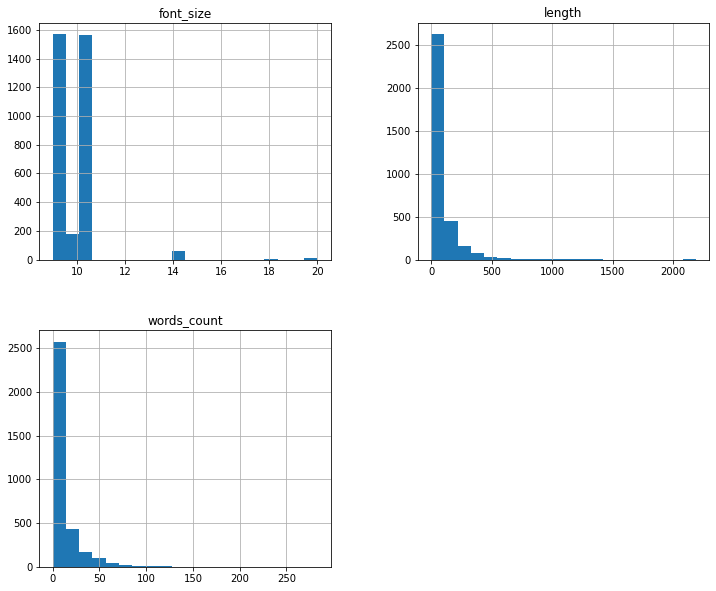

In [9]:
data.hist(figsize=(12, 10), bins=20);

Из гистограмм видим:
1. Размер кегля преобладает 9 и 10,5;  


2. Длина абазаца в символах в большинстве случаев - около 100, впятеро меньше абзацев длиной 200-300 символом.  
Также есть огромные абзацы длиной от 500 до 2188 символов, но их количество крайне мало;  


3. Аналогична ситуация со словами - большинство абзацев содержат до 25 слов.

In [10]:
style_pivot = data.pivot_table(
    index=['style_group', 'style'],
    #columns='content',
    values=['words_count', 'length'], 
    aggfunc=['count', 'mean']
    ).reset_index()

style_pivot.columns = ['_'.join(col) for col in style_pivot.columns]

style_pivot

,style_group_,style_,count_length,count_words_count,mean_length,mean_words_count
0,Преамбулы к главе,Преамбула к главе внутри,119,119,79.949580,10.579832
1,Преамбулы к главе,Преамбула к главе конец,10,10,46.000000,5.800000
2,Преамбулы к главе,Преамбула к главе начало,10,10,1080.000000,146.700000
3,Пример с плашкой,Пример с плашкой_ Внутри,228,228,88.399123,13.951754
4,Пример с плашкой,Пример с плашкой_ Заголовок,90,90,9.966667,1.988889
5,Пример с плашкой,Пример с плашкой_Без плашки,1,1,88.000000,12.000000
6,Пример с плашкой,Пример с плашкой_Конец,43,43,152.883721,23.488372
7,Пример с плашкой,Пример формула конец,33,33,1.181818,1.030303
8,Пример с плашкой рубленый,Пример с плашкой_Без плашки,2,2,196.500000,26.500000
9,Пример с плашкой рубленый,Пример с плашкой_Конец,1,1,108.000000,13.000000


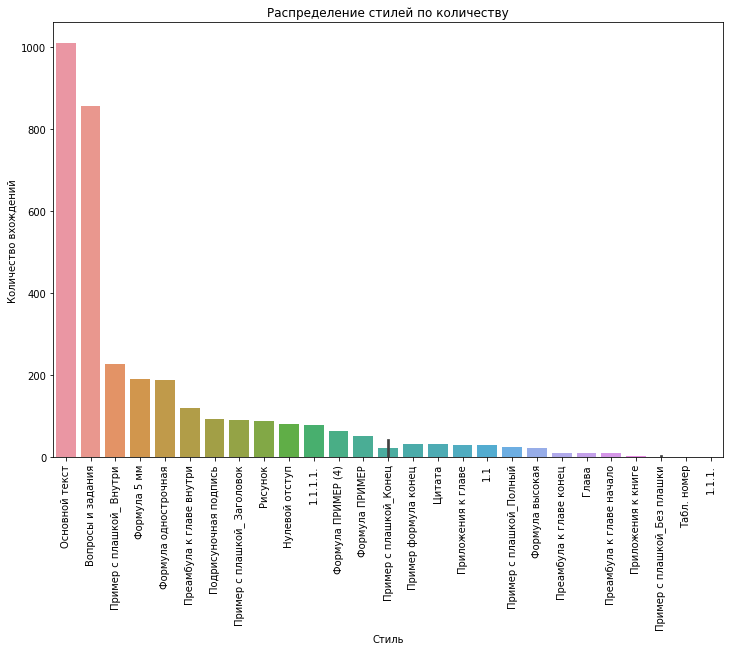

In [11]:
sns.barplot(
    x=style_pivot.sort_values(by='count_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='count_length', ascending=False)['count_length']
    )

plt.title('Распределение стилей по количеству')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


Очевидно, но основной текст - наиболее часто используемый стиль.

Учебник также достаточно сильно насцщен контрольными вопросами и заданиями.

Довольно большое количество рисунков, много формул.  
Вероятно, это книжка по естественно-научной дисциплине :)

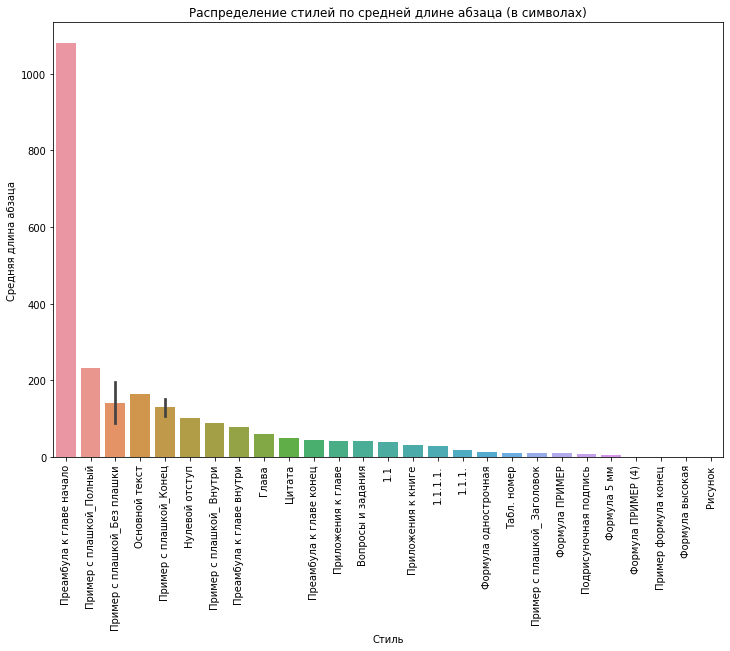

In [12]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_length', ascending=False)['mean_length']
    )

plt.title('Распределение стилей по средней длине абзаца (в символах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


Странный лидер графика.  
Не видя текста, но зная структуру учебников, вполне можно предположить, что каждая глава содержит объемное вступление в преамбуле.  
Также отмечу довольно большой объем замечаний (стили "Пример с плашкой полный" и "...без плашки").

Основной текст лишь на 4 месте со средней длиной абзаца около 200 символов.  
Возможно, статистика слегка прихрамывает из-за формул (которые считаются за один символ), но общую тенденцию тем не менее отражает

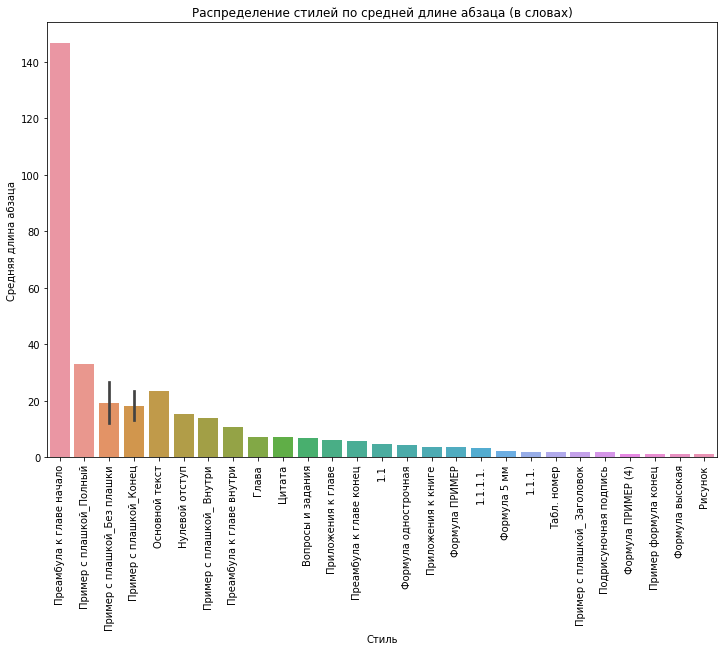

In [13]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_words_count', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_words_count', ascending=False)['mean_words_count']
    )

plt.title('Распределение стилей по средней длине абзаца (в словах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


И практически аналогичная картина при анализе по количеству слов.

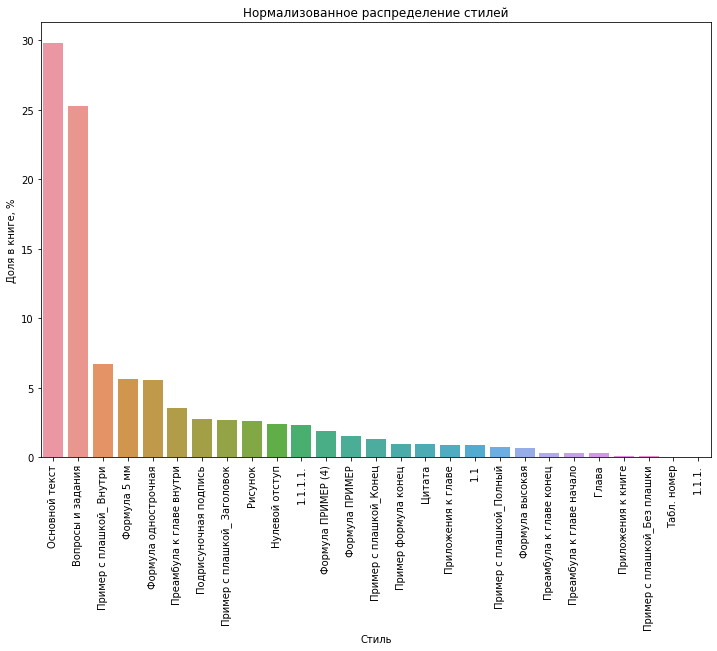

In [14]:
sns.barplot(
    x=data['style'].value_counts(normalize=True).index,
    y=data['style'].value_counts(normalize=True).values*100
    )

plt.title('Нормализованное распределение стилей')
plt.xlabel('Стиль')
plt.ylabel('Доля в книге, %')
plt.xticks(rotation=90);

## Расширение данных

Добавим еще пару книг для увеличения объема данных

In [15]:
# Переопределим документ 
my_doc = app.ActiveDocument

# Добавим стили, если их нет
add_styles()

# Определим main_story
main_story2 = get_main_story()

# Разобьем на абзацы и создадим еще один датафрейм
pre_data2 = get_paragraphs(main_story2)
data2 = features_engineering(pre_data2)

data2

Styles is on!!!!
Max story length: 5836 
Stories: 1643 
Max story index: 4
Paragraphs in max story: 5836


,paragraph,content,style_group,style,prev_style,next_style,font_name,font_size,is_pict_on,is_table_on,is_eqn_on,length,words_count
0,<COMObject Item>,﻿Предисловие,навигация по книге,Приложения к книге,NaN,Основной текст,Myriad Pro,18.0,False,False,False,12,1
1,<COMObject Item>,Настоящее пособие написано в соответствии с ак...,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,False,False,False,176,19
2,<COMObject Item>,"Известно, что решение задач по математике у ст...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,261,37
3,<COMObject Item>,При самостоятельном решении задач многие студе...,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,293,40
4,<COMObject Item>,В каждом параграфе приведены краткие теоретиче...,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,528,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5830,<COMObject Item>,Зачетная работа. Вариант 1. 1) y = (x2 + 1)2; ...,основной набор,Основной текст,Нулевой отступ,1.1.1.1.,CharterITC,10.5,False,False,False,264,74
5831,<COMObject Item>,Глава 16,навигация по книге,1.1.1.1.,Основной текст,Основной текст,CharterITC,10.5,False,False,False,8,2
5832,<COMObject Item>,7. \t1) 2730; 2) (m - 1)(m - 2) ⋅ … ⋅ 6 ⋅ 5. 8...,основной набор,Основной текст,1.1.1.1.,Нулевой отступ,CharterITC,10.5,False,False,False,214,64
5833,<COMObject Item>,3) ￼. 17. 1) ￼; 2) ￼; 3) ￼. 18. 1) n ≤ 4;,основной набор,Нулевой отступ,Основной текст,Нулевой отступ,CharterITC,10.5,False,False,False,41,14


Тоже мельком посмотрим на статистику по этой книге

In [16]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5835 entries, 0 to 5834
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   paragraph    5835 non-null   object 
 1   content      5835 non-null   object 
 2   style_group  5835 non-null   object 
 3   style        5835 non-null   object 
 4   prev_style   5834 non-null   object 
 5   next_style   5834 non-null   object 
 6   font_name    5835 non-null   object 
 7   font_size    5835 non-null   float64
 8   is_pict_on   5835 non-null   bool   
 9   is_table_on  5835 non-null   bool   
 10  is_eqn_on    5835 non-null   bool   
 11  length       5835 non-null   int64  
 12  words_count  5835 non-null   int64  
dtypes: bool(3), float64(1), int64(2), object(7)
memory usage: 473.1+ KB


In [17]:
data2.describe()

,font_size,length,words_count
count,5835.000000,5835.000000,5835.000000
mean,10.069751,69.411997,14.095973
std,1.215622,132.487622,35.483801
min,9.000000,0.000000,0.000000
25%,9.000000,15.000000,4.000000
50%,10.500000,42.000000,9.000000
75%,10.500000,84.000000,17.000000
max,35.000000,5593.000000,1734.000000


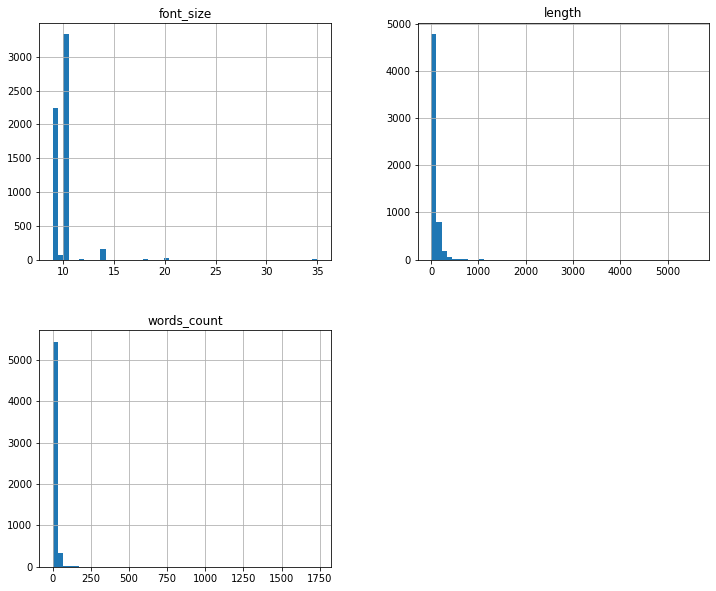

In [18]:
data2.hist(figsize=(12, 10), bins=50);

Из гистограмм видим:
1. Размер кегля преобладает 9 и 10,5;  


2. Снова преобладают короткие абзацы.  
Также есть огромные абзацы длиной более 1000 символов, но их количество крайне мало;  


3. Аналогична ситуация со словами - большинство абзацев содержат до 25 слов.

In [19]:
style_pivot = data2.pivot_table(
    index=['style_group', 'style'],
    #columns='content',
    values=['words_count', 'length'], 
    aggfunc=['count', 'mean']
    ).reset_index()

style_pivot.columns = ['_'.join(col) for col in style_pivot.columns]

style_pivot

,style_group_,style_,count_length,count_words_count,mean_length,mean_words_count
0,Безымянный-2,[основной абзац],8,8,0.000000,0.000000
1,Петиты,Петит Внутри,696,696,76.899425,14.875000
2,Петиты,Петит Начало,347,347,102.755043,19.665706
3,Петиты,Петит Окончание,226,226,83.269912,16.659292
4,Петиты,Петит Полный,37,37,184.486486,37.162162
5,Пример с плашкой,Пример с плашкой_ Внутри,1,1,62.000000,7.000000
6,Рисунок,Подрисуночная подпись,94,94,9.404255,2.287234
7,Рисунок,Рисунок,88,88,1.000000,1.000000
8,Таблица,Табл. номер,6,6,11.000000,2.000000
9,Формулы,Формула 5 мм,120,120,7.658333,2.008333


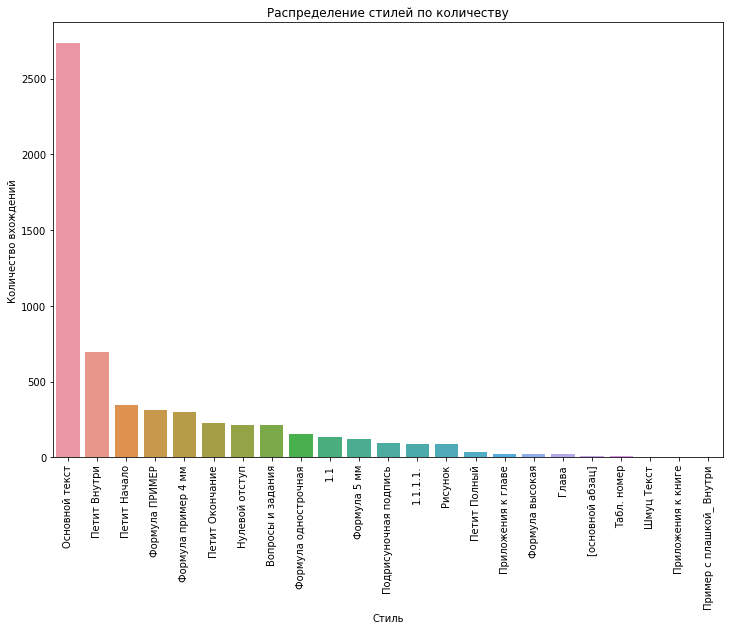

In [20]:
sns.barplot(
    x=style_pivot.sort_values(by='count_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='count_length', ascending=False)['count_length']
    )

plt.title('Распределение стилей по количеству')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


Аналогично предыдущей книге, основной текст - наиболее часто используемый стиль.

Но в отличие от предыдущего, этот учебник имеет гораздо меньше контрольных вопросов.  
Зато куда как более щедр на примеры (стиль "Петит").

Снова большое количество формул, но рисунков уже меньше (~100).  
Опять можно сделать вывод, что это книжка по естественно-научной дисциплине.

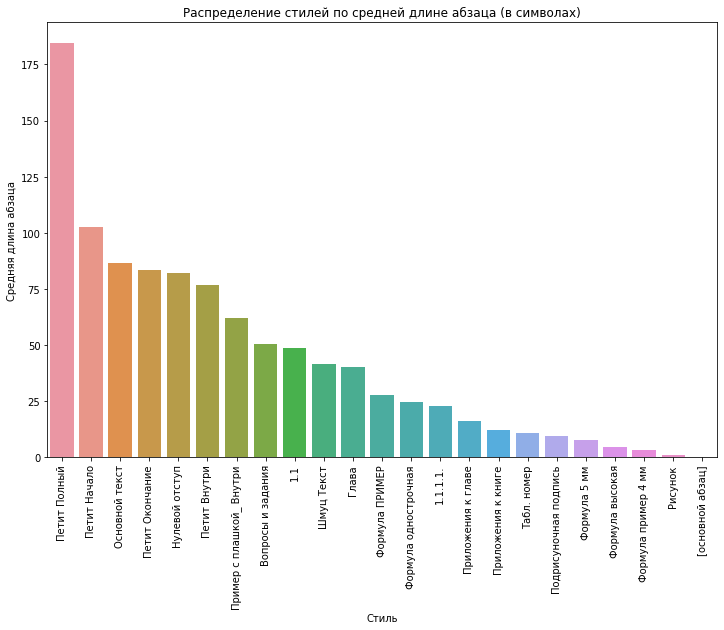

In [21]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_length', ascending=False)['mean_length']
    )

plt.title('Распределение стилей по средней длине абзаца (в символах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


Самые длинные абзацы - в примерах.
Основной текст лишь имеет абзацы со средней длиной около 85 символов.  
Хотя исходя из названия ("Практические задания по математике"), все становится на свои места:  
текст насущен недлинными условиями задач.


Возможно, статистика слегка прихрамывает из-за формул (которые считаются за один символ), но общую тенденцию тем не менее отражает.

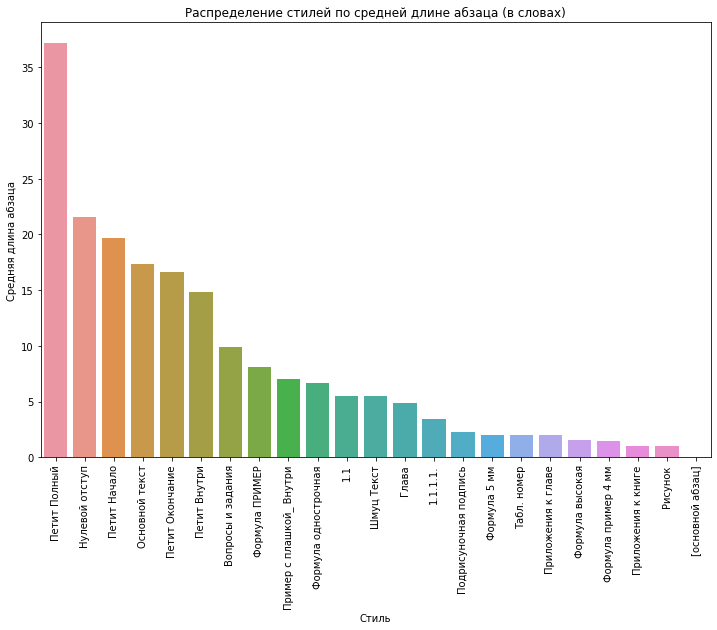

In [22]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_words_count', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_words_count', ascending=False)['mean_words_count']
    )

plt.title('Распределение стилей по средней длине абзаца (в словах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


И практически аналогичная картина при анализе по количеству слов.

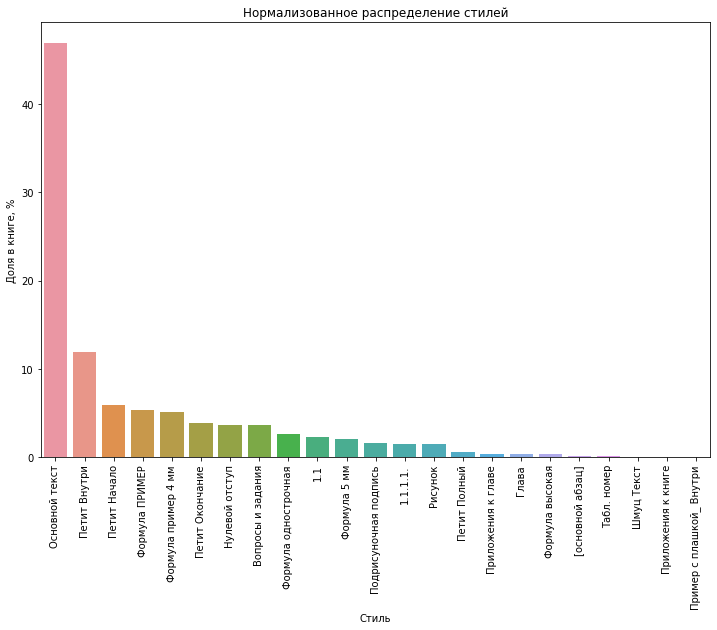

In [23]:
sns.barplot(
    x=data2['style'].value_counts(normalize=True).index,
    y=data2['style'].value_counts(normalize=True).values*100
    )

plt.title('Нормализованное распределение стилей')
plt.xlabel('Стиль')
plt.ylabel('Доля в книге, %')
plt.xticks(rotation=90);

Здесь почти половину абзацев всего текста составляет основной текст.

In [24]:
# Переопределим документ 
my_doc = app.ActiveDocument

# Добавим стили, если их нет
add_styles()

# Определим main_story
main_story3 = get_main_story()

# Разобьем на абзацы и создадим еще один датафрейм
pre_data3 = get_paragraphs(main_story3)
data3 = features_engineering(pre_data3)

data3

Styles is on!!!!
Max story length: 2515 
Stories: 766 
Max story index: 4
Paragraphs in max story: 2515


,paragraph,content,style_group,style,prev_style,next_style,font_name,font_size,is_pict_on,is_table_on,is_eqn_on,length,words_count
0,<COMObject Item>,﻿Список сокращений,навигация по книге,Приложения к книге,NaN,Основной текст,Myriad Pro,18.0,False,False,False,18,2
1,<COMObject Item>,АД — артериальное давление,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,False,False,False,26,4
2,<COMObject Item>,АДГ — антидиуретический гормон (вазопрессин),основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,44,5
3,<COMObject Item>,АКТГ — адренокортикотропный гормон,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,34,4
4,<COMObject Item>,АТФ — аденозинтрифосфат,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,23,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,<COMObject Item>,"11.\tФесенко, Ю. А. Возрастная физиология и пс...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,213,35
2510,<COMObject Item>,"12.\tВведенский, Н. Е. Избранные сочинения по ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,158,29
2511,<COMObject Item>,"13.\tМечников, И. И. Этюды о природе человека ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,147,28
2512,<COMObject Item>,"14.\tПавлов, И. П. Лекции о работе главных пищ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,146,26


Тоже мельком посмотрим на статистику по этой книге

In [25]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   paragraph    2514 non-null   object 
 1   content      2514 non-null   object 
 2   style_group  2514 non-null   object 
 3   style        2514 non-null   object 
 4   prev_style   2513 non-null   object 
 5   next_style   2513 non-null   object 
 6   font_name    2514 non-null   object 
 7   font_size    2514 non-null   float64
 8   is_pict_on   2514 non-null   bool   
 9   is_table_on  2514 non-null   bool   
 10  is_eqn_on    2514 non-null   bool   
 11  length       2514 non-null   int64  
 12  words_count  2514 non-null   int64  
dtypes: bool(3), float64(1), int64(2), object(7)
memory usage: 203.9+ KB


In [26]:
data3.describe()

,font_size,length,words_count
count,2514.000000,2514.000000,2514.000000
mean,10.398767,300.151551,38.864757
std,1.235901,317.639890,40.297837
min,9.000000,0.000000,0.000000
25%,10.000000,53.000000,7.000000
50%,10.500000,168.500000,23.500000
75%,10.500000,483.000000,61.000000
max,35.000000,1886.000000,256.000000


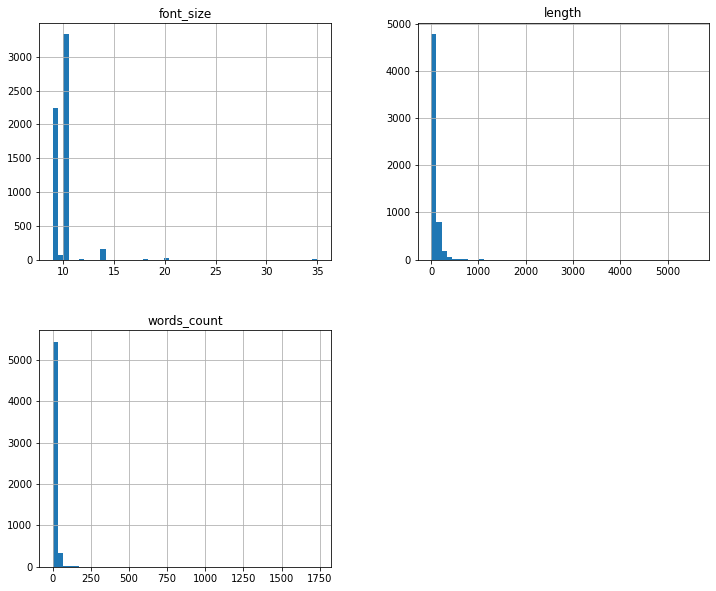

In [27]:
data2.hist(figsize=(12, 10), bins=50);

Из гистограмм видим:
1. Размер кегля преобладает 9 и 10,5;  


2. Снова преобладают короткие абзацы.  
Абзацы относительно прошлых книг доходят до 5000 символов;  


3. Аналогична ситуация со словами - есть абзацы в 1750 слов.

In [28]:
style_pivot = data3.pivot_table(
    index=['style_group', 'style'],
    #columns='content',
    values=['words_count', 'length'], 
    aggfunc=['count', 'mean']
    ).reset_index()

style_pivot.columns = ['_'.join(col) for col in style_pivot.columns]

style_pivot

,style_group_,style_,count_length,count_words_count,mean_length,mean_words_count
0,Преамбулы к главе,Преамбула к главе внутри,56,56,47.428571,6.053571
1,Преамбулы к главе,Преамбула к главе конец,5,5,38.400000,5.000000
2,Преамбулы к главе,Преамбула к главе начало,6,6,49.000000,7.000000
3,Пример с плашкой,Пример с плашкой_Конец,1,1,37.000000,5.000000
4,Рисунок,Легенда,64,64,145.031250,21.890625
5,Рисунок,Подрисуночная подпись,214,214,65.205607,8.677570
6,Рисунок,Рисунок,212,212,1.070755,1.028302
7,Рисунок,Рисунок - текст,1,1,0.000000,0.000000
8,Таблица,Табл. заголовок,12,12,57.916667,6.583333
9,Таблица,Табл. номер,12,12,11.000000,2.000000


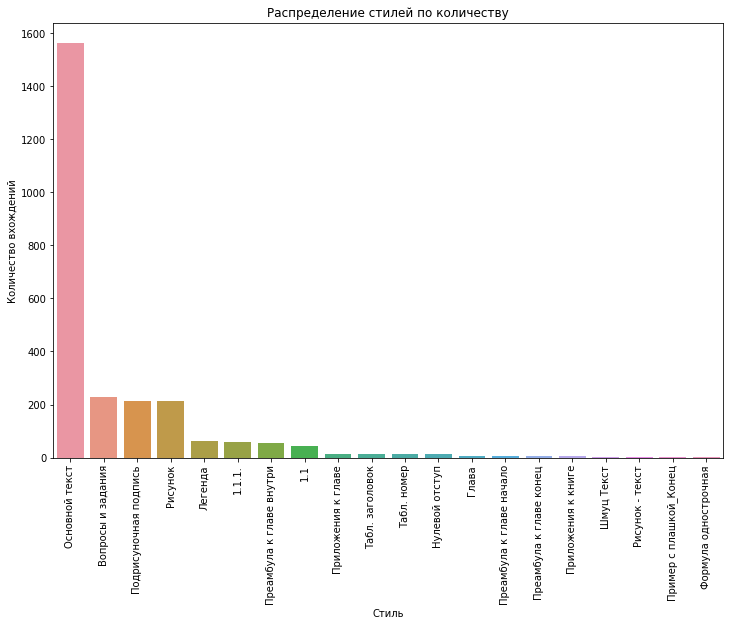

In [29]:
sns.barplot(
    x=style_pivot.sort_values(by='count_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='count_length', ascending=False)['count_length']
    )

plt.title('Распределение стилей по количеству')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


Аналогично предыдущей книге, основной текст - наиболее часто используемый стиль.

Также меньше контрольных вопросов, но изобилует рисунками (около 200 шт.).

Формул совсем нет. В наиболее часто используемых стилях видим практически все заголовки.  
Можно сделать вывод, что книга довольно простая по структуре (основной текст + рисунки + заголовки).

Также в конце графика стиль конца примера ненавязчиво намекает, что он где-то ошибочно использован,  
поскольку нет ни начала, ни середины примера. 

Отметим этот факт как возможность генерации дополнительного признака о неправильной разметке.  

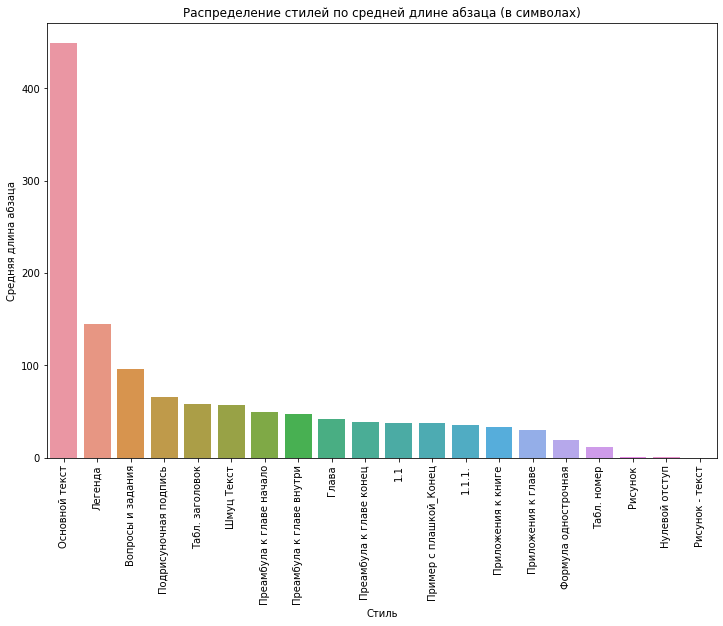

In [30]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_length', ascending=False)['mean_length']
    )

plt.title('Распределение стилей по средней длине абзаца (в символах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


Самые длинные абзацы - основной текст - около 500 символов в среднем.  
Также заметим обширные легенды к рисункам.

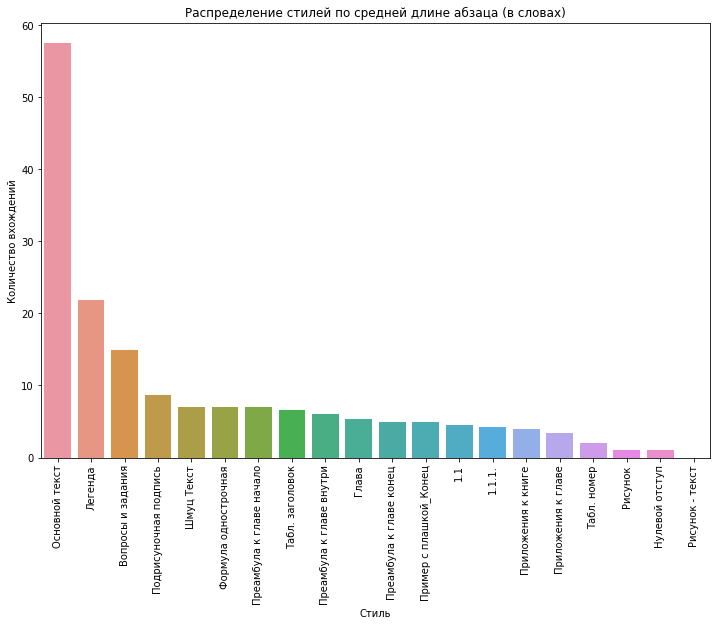

In [31]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_words_count', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_words_count', ascending=False)['mean_words_count']
    )

plt.title('Распределение стилей по средней длине абзаца (в словах)')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


И практически аналогичная картина при анализе по количеству слов.

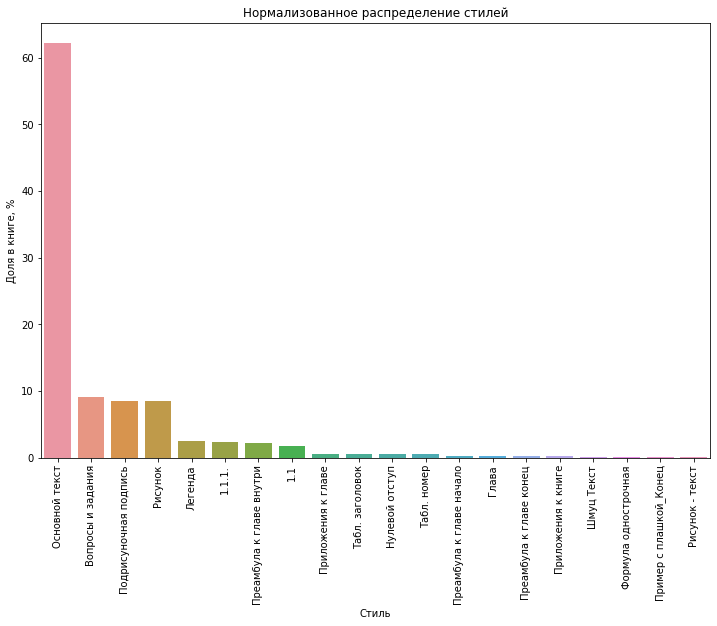

In [32]:
sns.barplot(
    x=data3['style'].value_counts(normalize=True).index,
    y=data3['style'].value_counts(normalize=True).values*100
    )

plt.title('Нормализованное распределение стилей')
plt.xlabel('Стиль')
plt.ylabel('Доля в книге, %')
plt.xticks(rotation=90);

Более 60 % книги - основной текст.  

## Предобработка данных

Объединим данные.

In [89]:
full_data = pd.concat([data, data2, data3])

full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11738 entries, 0 to 2513
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   paragraph    11738 non-null  object 
 1   content      11738 non-null  object 
 2   style_group  11738 non-null  object 
 3   style        11738 non-null  object 
 4   prev_style   11735 non-null  object 
 5   next_style   11735 non-null  object 
 6   font_name    11738 non-null  object 
 7   font_size    11738 non-null  float64
 8   is_pict_on   11738 non-null  bool   
 9   is_table_on  11738 non-null  bool   
 10  is_eqn_on    11738 non-null  bool   
 11  length       11738 non-null  int64  
 12  words_count  11738 non-null  int64  
dtypes: bool(3), float64(1), int64(2), object(7)
memory usage: 1.0+ MB


In [90]:
full_data.fillna('None', inplace=True)

Проверим на пустые строки

In [91]:
full_data.query('content == ""')

,paragraph,content,style_group,style,prev_style,next_style,font_name,font_size,is_pict_on,is_table_on,is_eqn_on,length,words_count
1320,<COMObject Item>,,основной набор,Вопросы и задания,Основной текст,Глава,CharterITC,9.0,False,False,False,0,0
1973,<COMObject Item>,,основной набор,Вопросы и задания,Вопросы и задания,Вопросы и задания,CharterITC,9.0,False,False,False,0,0
3353,<COMObject Item>,,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,0,0
21,<COMObject Item>,,навигация по книге,Глава,Шмуц Текст,Глава,Myriad Pro,20.0,False,False,False,0,0
103,<COMObject Item>,,Безымянный-2,[основной абзац],Основной текст,Глава,Minion Pro,12.0,False,False,False,0,0
341,<COMObject Item>,,основной набор,Основной текст,Вопросы и задания,Шмуц Текст,CharterITC,10.5,False,False,False,0,0
343,<COMObject Item>,,навигация по книге,Глава,Шмуц Текст,Глава,Myriad Pro,20.0,False,False,False,0,0
1016,<COMObject Item>,,основной набор,Основной текст,Вопросы и задания,[основной абзац],CharterITC,10.5,False,False,False,0,0
1017,<COMObject Item>,,Безымянный-2,[основной абзац],Основной текст,Глава,Minion Pro,12.0,False,False,False,0,0
1352,<COMObject Item>,,основной набор,Основной текст,Основной текст,Глава,CharterITC,10.5,False,False,False,0,0


In [92]:
full_data = full_data.query('content != ""')

In [93]:
full_data['style_group'].unique()

array(['навигация по книге', 'основной набор', 'Преамбулы к главе',
       'Пример с плашкой', 'Формулы', 'Пример с плашкой рубленый',
       'Таблица', 'Рисунок', 'Петиты'], dtype=object)

In [94]:
full_data['style'].unique()

array(['Приложения к книге', 'Основной текст', 'Глава', 'Цитата',
       'Преамбула к главе начало', 'Преамбула к главе внутри',
       'Преамбула к главе конец', '1.1', '1.1.1.1.',
       'Пример с плашкой_ Заголовок', 'Пример с плашкой_ Внутри',
       'Пример с плашкой_Конец', 'Формула однострочная',
       'Пример с плашкой_Полный', 'Формула 5 мм', 'Табл. номер',
       'Формула ПРИМЕР', 'Рисунок', 'Подрисуночная подпись',
       'Нулевой отступ', 'Приложения к главе', 'Вопросы и задания',
       'Формула высокая', 'Формула ПРИМЕР (4)', 'Пример формула конец',
       'Пример с плашкой_Без плашки', '1.1.1.', 'Шмуц Текст',
       'Петит Начало', 'Петит Окончание', 'Петит Полный', 'Петит Внутри',
       'Формула пример 4 мм', 'Легенда', 'Табл. заголовок'], dtype=object)

In [3]:
full_data.groupby(['style_group', 'style'])['font_name'].agg('count').sort_values()

style_group                style                      
Пример с плашкой рубленый  Пример с плашкой_Конец            1
Пример с плашкой           Пример с плашкой_Без плашки       1
Пример с плашкой рубленый  Пример с плашкой_Без плашки       2
навигация по книге         Шмуц Текст                        5
                           Приложения к книге                9
Таблица                    Табл. заголовок                  12
Преамбулы к главе          Преамбула к главе конец          15
                           Преамбула к главе начало         16
Таблица                    Табл. номер                      19
Пример с плашкой рубленый  Пример с плашкой_Полный          26
основной набор             Цитата                           31
Пример с плашкой           Пример формула конец             33
навигация по книге         Глава                            33
Петиты                     Петит Полный                     37
Формулы                    Формула высокая                  41


In [ ]:
full_data.to_csv('Data/dataset.csv')

## Краткий вывод

Для подготовки данных к машинному обучению создан набор данных из трех книг.

Данные бегло исследованы, объединены в один датафрейм.

Удалены строки без значений конетента, остальные признаки проверены на адекватность значений.

## Подготовка данных для машинного обучения



In [41]:
full_data = pd.read_csv('Data\dataset.csv')

full_data

,Unnamed: 0,paragraph,content,style_group,style,prev_style,next_style,font_name,font_size,is_pict_on,is_table_on,is_eqn_on,length,words_count
0,0,<COMObject Item>,﻿Предисловие,навигация по книге,Приложения к книге,None,Основной текст,Myriad Pro,18.0,False,False,False,12,1
1,1,<COMObject Item>,﻿Предлагаемый курс возник как итог многолетней...,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,False,False,False,1000,114
2,2,<COMObject Item>,﻿Данный курс адресован в первую очередь студен...,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,739,88
3,3,<COMObject Item>,"Преамбула, с которой начинается каждая ﻿тема, ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,564,76
4,4,<COMObject Item>,"Излагая теорию, авторы зачастую отказываются о...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,831,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11689,2509,<COMObject Item>,"11.\tФесенко, Ю. А. Возрастная физиология и пс...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,213,35
11690,2510,<COMObject Item>,"12.\tВведенский, Н. Е. Избранные сочинения по ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,158,29
11691,2511,<COMObject Item>,"13.\tМечников, И. И. Этюды о природе человека ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,147,28
11692,2512,<COMObject Item>,"14.\tПавлов, И. П. Лекции о работе главных пищ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,146,26


In [42]:
ohe_cols = ['font_size', 'is_pict_on','is_table_on','is_eqn_on', 'style_group', 'font_name']
me_cols = ['prev_style', 'next_style',]
category_cols = ohe_cols + me_cols


numeric_cols = ['length', 'words_count']

X = full_data[ohe_cols + me_cols + numeric_cols]
y = full_data['style']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    train_size=.8, 
    random_state=RS,
    #stratify=y
    )

# X_train[numeric_cols] = X_train[numeric_cols].astype('float')
# X_test[numeric_cols] = X_test[numeric_cols].astype('float')

In [43]:
X_train[category_cols] = X_train[category_cols].astype('category')
X_test[category_cols] = X_test[category_cols].astype('category')

X_train[numeric_cols] = X_train[numeric_cols].astype('float')
X_test[numeric_cols] = X_test[numeric_cols].astype('float')

In [44]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_test = le.transform(y_test)

Создадим пайплайн обработки

In [45]:
num_imputer = SimpleImputer(strategy='median')
std_scaler = StandardScaler()
cat_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
me_encoder = MEstimateEncoder()

pipe_num = Pipeline([('imputer', num_imputer), ('scaler', std_scaler)])

pipe_ohe = Pipeline([('ohe_encoder', ohe_encoder)])

pipe_me = Pipeline([('me_encoder', me_encoder)])

col_transformer = ColumnTransformer([('num_preproc', pipe_num, numeric_cols),
                                     ('ohe_preproc', pipe_ohe, ohe_cols),
                                     ('me_prerpoc', pipe_me, me_cols)
                                    ])

fin_pipe = Pipeline([('full_prep', col_transformer)])

In [46]:
X_train_transformed = fin_pipe.fit_transform(X_train, y_train)

X_test_transformed = fin_pipe.transform(X_test)




c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### LogisticRegression

In [10]:
model_lr = LogisticRegression(random_state=RS, max_iter=10000, verbose=0)

model_lr.fit(X_train_transformed, y_train)

scores = cross_val_score(model_lr, X_train_transformed, y_train, scoring='f1_weighted')



print('F1-score:', scores.mean())

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


F1-score: 0.9062352628879019


Подберем гиперпараметры с помощью Optuna

In [11]:
def objective_lr(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    tol = trial.suggest_float("tol", 0.0001, 0.01, log=True)
    C = trial.suggest_float("C", 1.0, 10.0, log=True)
    intercept = trial.suggest_categorical("fit_intercept", [True, False])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    classifier = LogisticRegression(random_state=RS, 
                                    max_iter=5000,
                                    penalty=penalty,
                                    tol=tol,
                                    C=C,
                                    fit_intercept=intercept,
                                    solver=solver,
                                    multi_class='auto',
                                    n_jobs=-1,
                                    verbose=0
                                   )
    
    classifier.fit(X_train_transformed, y_train)

    scores = cross_val_score(classifier, X_train_transformed, y_train, scoring='f1_weighted')

    return scores.mean()

In [12]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=RS)

study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize", sampler=sampler)
study_lr.optimize(objective_lr, n_trials=100)

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.p

In [13]:
print('Number of finished trials: ', len(study_lr.trials))
print('Best trial:')
trial = study_lr.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  0.9175914488832613
  Params: 
    penalty: l1
    tol: 0.0003262051712428323
    C: 9.346808507389532
    fit_intercept: True
    solver: liblinear


In [14]:
best_f1_LR = trial.value
best_model_LR = LogisticRegression(**trial.params, random_state=RS)

#### LightGBM

In [15]:
# Функция подбора гиперпараметров LightGBM

def objective_LGBM(trial):
    params = {
        # Hyperparameter settings
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 6, 306, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 1000, step=50),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.95),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0.1, 100, step=1),
        "lambda_l2": trial.suggest_int("lambda_l2", 0.1, 100, step=1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95),
        
    }
    
    model = LGBMClassifier(**params, class_weight='balanced', n_jobs=-1, random_state=RS, verbose=-1)  
    
    model.fit(X_train_transformed, y_train)
    
    scores = cross_val_score(model, X_train_transformed, y_train, scoring='f1_weighted')
    
    
    return scores.mean()

In [16]:
study_LGBM = optuna.create_study(study_name="LightGBM", direction="maximize", sampler=sampler)
study_LGBM.optimize(objective_LGBM, n_trials=100)

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated

In [17]:
print('Number of finished trials: ', len(study_LGBM.trials))
print('Best trial:')
trial = study_LGBM.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  0.9069312614794329
  Params: 
    n_estimators: 950
    learning_rate: 0.22183153795407862
    num_leaves: 86
    max_depth: 5
    min_data_in_leaf: 200
    min_gain_to_split: 0.962626879200462
    bagging_fraction: 0.8949728471141492
    max_bin: 287
    lambda_l1: 4
    lambda_l2: 41
    bagging_freq: 1
    feature_fraction: 0.22771746117269812


In [18]:
best_f1_LGBM = trial.value
best_model_LGBM = LGBMClassifier(**trial.params, random_state=RS)

#### CatBoost

Кодированные данные

In [19]:
def objective_CB_enc(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 400, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 4, 10),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        "bootstrap_type" : trial.suggest_categorical('bootstrap_type', ['Bayesian']),
        "random_strength" : trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 10, 50)
    }
    

    model = CatBoostClassifier(**params, 
                              random_state=RS, 
                              verbose=False
    )

    model.fit(X_train_transformed, y_train)
    
    scores = cross_val_score(model, X_train_transformed, y_train, scoring='f1_weighted')
    
    
    return scores.mean()


In [20]:
study_CB_enc = optuna.create_study(study_name="catboost_enc", direction="maximize", sampler=sampler)
study_CB_enc.optimize(objective_CB_enc, n_trials=100)

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated

In [21]:
print('Number of finished trials: ', len(study_CB_enc.trials))
print('Best trial:')
trial = study_CB_enc.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  0.9390811470376749
  Params: 
    iterations: 781
    learning_rate: 0.059270570495098956
    depth: 4
    l2_leaf_reg: 0.8799933977437258
    bootstrap_type: Bayesian
    random_strength: 0.08829528574866197
    bagging_temperature: 0.44297943733436485
    od_type: IncToDec
    od_wait: 25


In [22]:
best_f1_CB_enc = trial.value
best_model_CB_enc = CatBoostClassifier(**trial.params, random_state=RS)

In [23]:
best_model_CB_enc.fit(X_train_transformed, y_train)

0:	learn: 2.3323447	total: 16.8ms	remaining: 13.1s
1:	learn: 2.0643375	total: 30.5ms	remaining: 11.9s
2:	learn: 1.8769706	total: 44.3ms	remaining: 11.5s
3:	learn: 1.7421429	total: 57.5ms	remaining: 11.2s
4:	learn: 1.5962112	total: 71.4ms	remaining: 11.1s
5:	learn: 1.4898801	total: 85.4ms	remaining: 11s
6:	learn: 1.3997258	total: 106ms	remaining: 11.7s
7:	learn: 1.3220365	total: 129ms	remaining: 12.4s
8:	learn: 1.2477368	total: 144ms	remaining: 12.4s
9:	learn: 1.1848932	total: 157ms	remaining: 12.1s
10:	learn: 1.1268176	total: 171ms	remaining: 12s
11:	learn: 1.0764736	total: 184ms	remaining: 11.8s
12:	learn: 1.0204303	total: 198ms	remaining: 11.7s
13:	learn: 0.9778934	total: 211ms	remaining: 11.6s
14:	learn: 0.9385743	total: 225ms	remaining: 11.5s
15:	learn: 0.9003243	total: 239ms	remaining: 11.4s
16:	learn: 0.8642614	total: 252ms	remaining: 11.3s
17:	learn: 0.8307481	total: 266ms	remaining: 11.3s
18:	learn: 0.7992301	total: 279ms	remaining: 11.2s
19:	learn: 0.7710976	total: 292ms	remai

Некодированнные данные

In [ ]:
# Тут помирает все (((( Подбор гиперпараметров поэтому закомментировал

def objective_CB_orig(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 400, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 4, 10),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        "bootstrap_type" : trial.suggest_categorical('bootstrap_type', ['Bayesian']),
        "random_strength" : trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 10, 50)
    }
    

    model = CatBoostClassifier(**params, 
                              random_state=RS, 
                              verbose=False,
                              cat_features=['is_pict_on', 
                                            'is_table_on', 
                                            'is_eqn_on', 
                                            'style_group', 
                                            'font_name', 
                                            'prev_style', 
                                            'next_style']
    )

    model.fit(X_train, y_train)
    
    scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted')
    
    
    return scores.mean()


In [ ]:
# study_CB_enc = optuna.create_study(study_name="catboost_orig", direction="minimize", sampler=sampler)
# study_CB_enc.optimize(objective_CB_orig, n_trials=100)

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated

In [ ]:
# print('Number of finished trials: ', len(study_CB_orig.trials))
# print('Best trial:')
# trial = study_CB_orig.best_trial
# print('  Value: ', trial.value)
# print('  Params: ')
# for key, value in trial.params.items():
#     print(f'    {key}: {value}')



Сведем результаты в таблицу.

In [26]:
best_model_LR.fit(X_train_transformed, y_train)

best_model_LGBM.fit(X_train_transformed, y_train)

best_model_CB_enc.fit(X_train_transformed, y_train)

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.22771746117269812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22771746117269812
[LightGBM] [Warning] min_gain_to_split is set=0.962626879200462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.962626879200462
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=41, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41
[LightGBM] [Warning] bagging_fraction is set=0.8949728471141492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8949728471141492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_

In [27]:
best_recall_LR = recall_score(y_train, best_model_LR.predict(X_train_transformed), average='weighted')
best_recall_LGBM = recall_score(y_train, best_model_LGBM.predict(X_train_transformed), average='weighted')
best_recall_CB = recall_score(y_train, best_model_CB_enc.predict(X_train_transformed), average='weighted')

best_precision_LR = precision_score(y_train, best_model_LR.predict(X_train_transformed), average='weighted')
best_precision_LGBM = precision_score(y_train, best_model_LGBM.predict(X_train_transformed), average='weighted')
best_precision_CB = precision_score(y_train, best_model_CB_enc.predict(X_train_transformed), average='weighted')

best_accuracy_LR = accuracy_score(y_train, best_model_LR.predict(X_train_transformed))
best_accuracy_LGBM = accuracy_score(y_train, best_model_LGBM.predict(X_train_transformed))
best_accuracy_CB = accuracy_score(y_train, best_model_CB_enc.predict(X_train_transformed))

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.22771746117269812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22771746117269812
[LightGBM] [Warning] min_gain_to_split is set=0.962626879200462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.962626879200462
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=41, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41
[LightGBM] [Warning] bagging_fraction is set=0.8949728471141492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8949728471141492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.22771746117269812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22771746117269812
[LightGBM] [Warning] min_gain_to_split is set=0.962626879200462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.962626879200462
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=41, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41
[LightGBM] [Warning] bagging_fraction is set=0.8949728471141492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8949728471141492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.22771746117269812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22771746117269812
[LightGBM] [Warning] min_gain_to_split is set=0.962626879200462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.962626879200462
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=41, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41
[LightGBM] [Warning] bagging_fraction is set=0.8949728471141492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8949728471141492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


<AxesSubplot:>

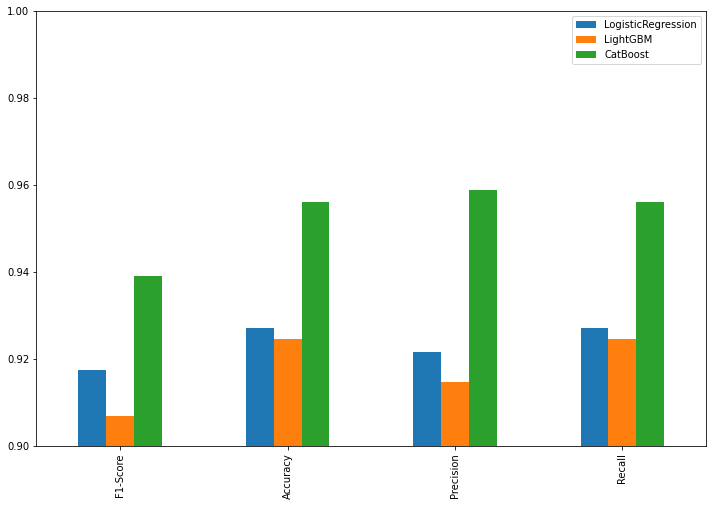

In [28]:
train_score = pd.DataFrame({
    'LogisticRegression' : [best_f1_LR, best_accuracy_LR, best_precision_LR, best_recall_LR],
    'LightGBM': [best_f1_LGBM, best_accuracy_LGBM, best_precision_LGBM, best_recall_LGBM],
    'CatBoost': [best_f1_CB_enc, best_accuracy_CB, best_precision_CB, best_recall_CB],
}, index=['F1-Score', 'Accuracy', 'Precision', 'Recall'])

train_score.plot(kind='bar', ylim=(0.9, 1))

Как видно, CatBoost показал себя лучше по всем метрикам

In [149]:
best_model_CB_enc.save_model(fname='Data//cb_model',
                             format="cbm",
                             export_parameters=None,
                             pool=None)

#### BERT

In [29]:
# Заново загрузим данные, так как лемматизация и очистка текста проходят внутри Берты
data_bert = pd.read_csv('Data\dataset.csv')

In [30]:
data_bert['content'] = data_bert['content'].apply(lambda x: x[:512])

In [31]:
# # Отрежем еще чуть-чуть, чтобы было кратно размеру батча
# data_small = data_small[:3900]

In [32]:
from transformers import BertForSequenceClassification

config = transformers.BertConfig.from_pretrained('cointegrated/rubert-tiny2')
model = transformers.BertModel.from_pretrained('cointegrated/rubert-tiny2')

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
tokenizer = transformers.AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')

tokenized = data_bert['content'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True)
)

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [34]:
padded.shape

(11694, 360)

In [35]:
batch_size = 32

embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/365 [00:00<?, ?it/s]

In [36]:
features = np.concatenate(embeddings)
target = data_bert['style'][:features.shape[0]]

X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(
                features, 
                target, 
                train_size=.8, 
                stratify=target, 
                random_state=RS
            )


In [37]:

LR_bert_parameters = {'C': [1, 5, 10],
                 'solver': ["liblinear", "saga"],
                 'penalty': ['l1', 'l2']

                }

LR_bert = LogisticRegression(random_state=RS)


LR_bert_grid = GridSearchCV(
    LR_bert, 
    param_grid=LR_bert_parameters,
    scoring='f1_weighted',
    cv=5,
    error_score='raise'
)

LR_bert_grid.fit(X_train, y_train)

best_f1_LR_bert = LR_bert_grid.best_score_
best_params_LR_bert = LR_bert_grid.best_params_

best_LR_bert = LR_bert_grid.best_estimator_


c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

In [38]:
best_f1_LR_bert

0.7382779035005547

In [39]:
f1_score(y_test, best_LR_bert.predict(X_test), average='weighted')

0.733533549902256

## Проверка на тестовой выборке

Проверим лучшую модель на тестовой выборке.

In [47]:
f1_score(y_test, best_model_CB_enc.predict(X_test_transformed), average='weighted')

0.9487498147486172

In [383]:
X_test_inversed = pd.DataFrame(X_test_transformed)
X_test_inversed

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.406923,-0.306646,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.513074,7.344386
1,0.149740,0.348023,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.197961,7.344386
2,-0.482403,-0.306646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,21.047872,9.241999
3,-0.548448,-0.477429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.100856,9.241999
4,-0.553165,-0.477429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.095453,4.152985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,-0.567318,-0.505893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,19.820460,18.497699
2335,-0.345596,-0.363574,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.100856,7.810540
2336,-0.491838,-0.363574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.095453,11.728265
2337,-0.364466,-0.164327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,19.820460,16.772311


In [404]:
# X_test_inversed = ohe_encoder.inverse_transform(X_train_transformed)
# X_test_inversed

ohe_cols_inversed = fin_pipe.named_steps['full_prep'].transformers_[1][1].named_steps['ohe_encoder'].get_feature_names_out(ohe_cols)
me_cols_inversed = fin_pipe.named_steps['full_prep'].transformers_[2][1].named_steps['me_encoder'].get_feature_names_out(me_cols)

cols_inversed = me_cols_inversed.tolist() + ohe_cols_inversed.tolist() + numeric_cols

X_test_inversed.columns = (x for x in cols_inversed)

X_test_inversed
#ohe_encoder.inverse_transform(X_test_inversed)

,prev_style,next_style,font_size_9.5,font_size_10.0,font_size_10.5,font_size_14.0,font_size_18.0,font_size_20.0,font_size_35.0,is_pict_on_1.0,...,style_group_Рисунок,style_group_Таблица,style_group_Формулы,style_group_навигация по книге,style_group_основной набор,font_name_Myriad Pro,font_name_SymbolPS,font_name_Times New Roman,length,words_count
0,-0.406923,-0.306646,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.513074,7.344386
1,0.149740,0.348023,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.197961,7.344386
2,-0.482403,-0.306646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,21.047872,9.241999
3,-0.548448,-0.477429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.100856,9.241999
4,-0.553165,-0.477429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.095453,4.152985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,-0.567318,-0.505893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,19.820460,18.497699
2335,-0.345596,-0.363574,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.100856,7.810540
2336,-0.491838,-0.363574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.095453,11.728265
2337,-0.364466,-0.164327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,19.820460,16.772311


Text(0, 0.5, 'Важность')

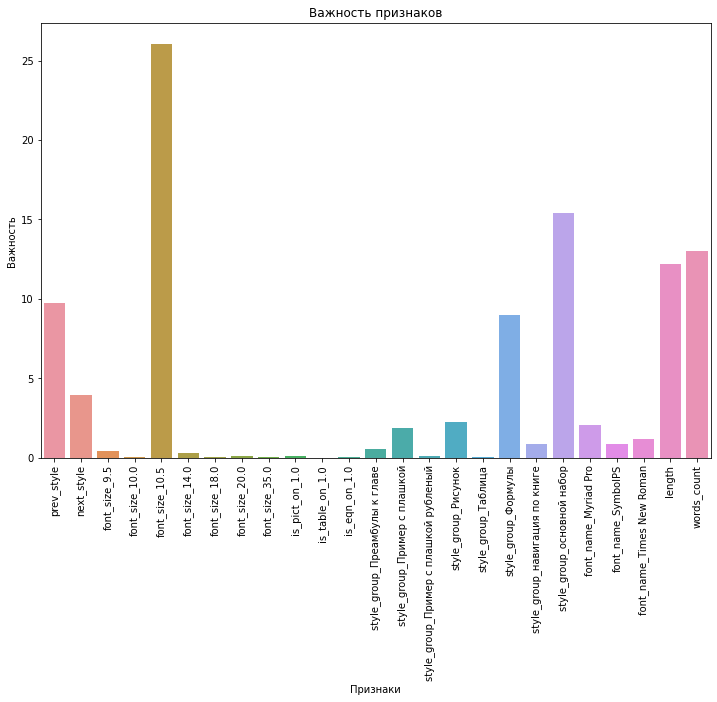

In [406]:
sns.barplot(
    x=X_test_inversed.columns,
    y=best_model_CB_enc.feature_importances_
)

plt.title('Важность признаков')
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Важность')

## Проверка в боевых условиях

In [256]:
# Переопределим документ 
my_doc_battletest = app.ActiveDocument

# Добавим стили, если их нет
add_styles()

# Определим main_story
main_story_battletest = get_main_story()

# Разобьем на абзацы и создадим еще один датафрейм
pre_data_battletest = get_paragraphs(main_story_battletest)
data_battletest = features_engineering(pre_data_battletest)

data_battletest

Max story length: 2524 
Stories: 767 
Max story index: 4
Paragraphs in max story: 2524


,paragraph,content,style_group,style,prev_style,next_style,font_name,font_size,is_pict_on,is_table_on,is_eqn_on,length,words_count
0,<COMObject Item>,﻿Список сокращений,навигация по книге,Приложения к книге,NaN,Основной текст,Myriad Pro,18.0,False,False,False,18,2
1,<COMObject Item>,АД — артериальное давление,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,False,False,False,26,4
2,<COMObject Item>,АДГ — антидиуретический гормон (вазопрессин),основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,44,5
3,<COMObject Item>,АКТГ — адренокортикотропный гормон,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,34,4
4,<COMObject Item>,АТФ — аденозинтрифосфат,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,23,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2519,<COMObject Item>,"12.\tВведенский, Н. Е. Избранные сочинения по ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,158,29
2520,<COMObject Item>,"13.\tМечников, И. И. Этюды о природе человека ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,147,28
2521,<COMObject Item>,"14.\tПавлов, И. П. Лекции о работе главных пищ...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,146,26
2522,<COMObject Item>,"15.\tСамойлов, А. Ф. О физиологии. Избранные с...",основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,False,False,False,142,26


In [249]:
real_styles = data_battletest['style']
data_battletest = data_battletest.drop(['paragraph', 'content', 'style'], axis=1)

In [250]:
data_battletest_transformed = fin_pipe.transform(data_battletest)

In [251]:
predictions = best_model_CB_enc.predict(data_battletest_transformed)
predictions = le.inverse_transform(predictions)

predictions.shape

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(2524,)

In [338]:
styles = {}
i = 0
for i, style in enumerate(my_doc_battletest.allParagraphStyles):
    styles[style.name] = i
    print(style)
    

[Без стиля]
[основной абзац]
Оборот титула
Библиография
Титул_Заголовки
Основной текст
Нулевой отступ
Цитата
Сноска
Вопросы и задания
Определение
Пример с плашкой_ Заголовок
Пример с плашкой_Без плашки
Пример с плашкой_ Внутри
Пример с плашкой_Полный
Пример с плашкой_Конец
Пример формула конец
Пример рисунок конец
Пример с плашкой_ Заголовок
Пример с плашкой_Без плашки
Пример с плашкой_ Внутри
Пример с плашкой_Полный
Пример с плашкой_Конец
Преамбула к главе начало
Преамбула к главе внутри
Преамбула к главе конец
Преамбула к главе полная
Подрисуночная подпись
Легенда
Рисунок - текст
Рисунок
Табл. заголовок
Табл. номер
Табл. текст
Табличная шапка
Примечение к таблице
Формула однострочная
Формула высокая
Формула ПРИМЕР
Формула 5 мм
Петит Начало
Петит Внутри
Петит Полный
Петит Окончание
Код_начало
Код_ Внутри
Код_Полный
Код_Конец
Шмуц Текст
Глава
1.1
1.1.1.
1.1.1.1.
Приложения к книге
Приложения к главе
(О) Раздел-часть
[О] Глава
(O) 1.1
(O) 11.1
(O) 11.11
(O) 1.1.1.
(О) Приложение к главе

In [347]:
for i in range(0, main_story_battletest.Paragraphs.Count):
    main_story_battletest.paragraphs.Item(i+1).appliedParagraphStyle = my_doc_battletest.allParagraphStyles[styles[predictions[i]]]


# Покрасить параграфы с изменением стиля!

In [348]:
res = pd.DataFrame({'real': real_styles, 'predictions': predictions},)

res.query('real != predictions')

#res

,real,predictions
74,Пример с плашкой_ Внутри,Пример с плашкой_ Заголовок
75,Пример с плашкой_ Внутри,Пример с плашкой_Конец
153,Пример с плашкой_ Внутри,Пример с плашкой_ Заголовок
158,Пример с плашкой_ Внутри,Пример с плашкой_ Заголовок
160,Формула однострочная,Формула 5 мм
161,Основной текст,Нулевой отступ
166,Преамбула к главе начало,Преамбула к главе внутри
167,Преамбула к главе начало,Преамбула к главе внутри
168,Преамбула к главе начало,Преамбула к главе внутри
169,Преамбула к главе начало,Преамбула к главе внутри
